In [4]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup # library for web scrapping  

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.8.2       |           py36_0         161 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.4.5.1         |           py36_0         159 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    soupsieve-2.0              |             py_0          33 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following NEW packages will be INSTALLED:

  beautifulsoup4     anaconda/linux-64::beautifulsoup4-4.8.2-py36_0
  soupsieve          anaconda/noarch::soupsieve-2.0-py_0

The following packages

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'BD3LCS0ZWIAYBXGJIG4SDZARX3UH4CXE1DTBVWL0REQEEE1U' # changed my Foursquare ID
    CLIENT_SECRET = 'U0MFUAX1PBFZAYQL12153DSWLZOKFYMMJQVGBMZCCSOO2ITO' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [7]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '###########################' # i have changed the id with ##
    CLIENT_SECRET = '############################' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

In [21]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venue = get_venues(Latitude,Longitude)
    mexican_resturants=venue[venue['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(new_york_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:2
done
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:2
done
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:2
done
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:6
done
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:3
done
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:3
done
( 10 / 306 ) Mexican Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Mexican Resturants in Baychester, Bronx:2
done
( 12 / 306 ) Mexican Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Mexican Resturants in City Island, Bronx:0
done
( 14 / 306 ) Mexican Resturants in Bedford Park, Bronx:3
done
( 15 / 306 ) Mexican Resturants in University Heights, Bronx:2
done
( 16 / 306 ) Mexican Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Mexican R

KeyError: 'groups'

In [22]:
mexican_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar
4,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente


In [23]:
mexican_rest_ny.shape

(248, 4)

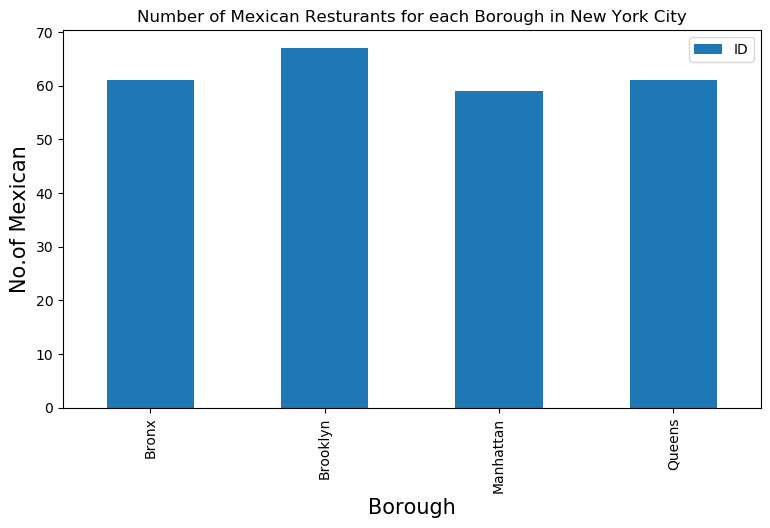

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

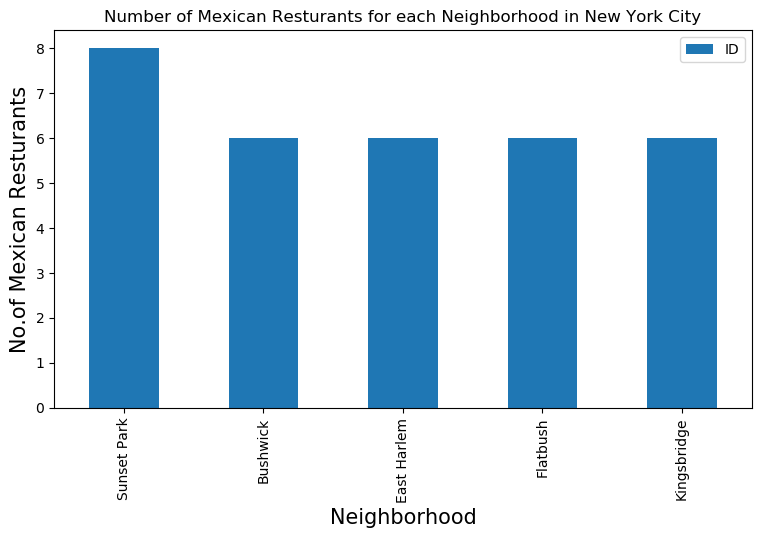

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [46]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'BD3LCS0ZWIAYBXGJIG4SDZARX3UH4CXE1DTBVWL0REQEEE1U' # i have changed the id with ##
    CLIENT_SECRET = 'U0MFUAX1PBFZAYQL12153DSWLZOKFYMMJQVGBMZCCSOO2ITO' # i have changed the secret with ##
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [47]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  5c47a4b21953f3002c558218  Chipotle Mexican Grill      0     7.5     0
( 1 / 248 ) processed
                         ID                   Name  Likes  Rating  Tips
0  58582b156431e554e165d909  Moe's Southwest Grill      1     6.7     0
( 2 / 248 ) processed
                         ID          Name  Likes  Rating  Tips
0  523f6e14498ef6fdefc0d690  Burrito Shop     10     7.0     4
( 3 / 248 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4b78ba71f964a5209fdf2ee3  Santa Fe Grill & Bar     11     6.2    17
( 4 / 248 ) processed
                         ID           Name  Likes  Rating  Tips
0  590e5d2ce96d0c61de2dcf1d  Cocina Chente     15     8.9     5
( 5 / 248 ) processed
                         ID    Name  Likes  Rating  Tips
0  4db45c96fa8c350240e35919  Metate     19     6.9    10
( 6 / 248 ) processed
                         ID                  Name  Likes  Rating  Ti

In [48]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.7,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,7.0,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.2,17
4,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente,15,8.9,5


In [49]:
mexican_rest_stats_ny.shape

(248, 7)

In [50]:
mexican_rest_ny.shape

(248, 4)

In [53]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny.csv', index=False)

In [65]:
mexican_rest_csv=pd.read_csv('mexican_rest_stats_ny.csv')

In [66]:
mexican_rest_csv.shape

(248, 7)

In [67]:
mexican_rest_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,0,7.5,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.7,0
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,7.0,4
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.2,17
4,Bronx,Riverdale,590e5d2ce96d0c61de2dcf1d,Cocina Chente,15,8.9,5


In [68]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       248 non-null    object 
 1   Neighborhood  248 non-null    object 
 2   ID            248 non-null    object 
 3   Name          248 non-null    object 
 4   Likes         248 non-null    object 
 5   Rating        248 non-null    float64
 6   Tips          248 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.7+ KB


In [74]:
mexican_rest_stats_ny['Likes']=mexican_rest_stats_ny['Likes'].astype('float64')

In [75]:
mexican_rest_stats_ny['Tips']=mexican_rest_stats_ny['Tips'].astype('float64')

In [76]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       248 non-null    object 
 1   Neighborhood  248 non-null    object 
 2   ID            248 non-null    object 
 3   Name          248 non-null    object 
 4   Likes         248 non-null    float64
 5   Rating        248 non-null    float64
 6   Tips          248 non-null    float64
dtypes: float64(3), object(4)
memory usage: 13.7+ KB


In [93]:
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1992
Rating                                 9
Tips                                 722
Name: 172, dtype: object

In [94]:
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a38273a005ac129b7a93010
Name                        La Loncheria
Likes                                 52
Rating                               9.2
Tips                                  15
Name: 92, dtype: object

In [95]:
mexican_rest_stats_ny.iloc[mexican_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1992
Rating                                 9
Tips                                 722
Name: 172, dtype: object

In [71]:
ny_neighborhood_stats=mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [72]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
57,Little Italy,9.000000
92,Soho,9.000000
43,Greenpoint,8.900000
106,Windsor Terrace,8.800000
41,Gramercy,8.766667
16,Chinatown,8.750000
103,West Village,8.700000
29,East Village,8.700000
60,Lower East Side,8.666667
40,Gowanus,8.650000


In [89]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [90]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
57,Little Italy,9.000000
92,Soho,9.000000
43,Greenpoint,8.900000
106,Windsor Terrace,8.800000
41,Gramercy,8.766667
16,Chinatown,8.750000
103,West Village,8.700000
29,East Village,8.700000
60,Lower East Side,8.666667
40,Gowanus,8.650000


In [91]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']


In [92]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.147458
1,Brooklyn,7.577612
0,Bronx,6.931148
3,Queens,6.831148


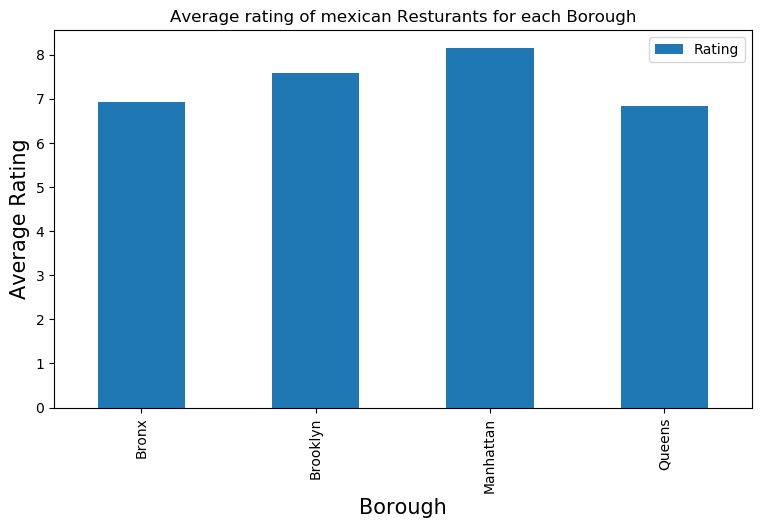

In [97]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of mexican Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [101]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [102]:
ny_neighborhood_stats

,Neighborhood,Average Rating
57,Little Italy,9.0
92,Soho,9.0


In [103]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [104]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [105]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Little Italy,40.719324,-73.997305,9.0
1,Manhattan,Soho,40.722184,-74.000657,9.0


In [106]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [107]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [108]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [109]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)